In [91]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import pickle

In [53]:
# Load the data
data = pd.read_csv('../input/family-income-and-expenditure/Family Income and Expenditure.csv', header=0)
print(data.shape)
print(data.dtypes)

(41544, 60)
Total Household Income                            int64
Region                                           object
Total Food Expenditure                            int64
Main Source of Income                            object
Agricultural Household indicator                  int64
Bread and Cereals Expenditure                     int64
Total Rice Expenditure                            int64
Meat Expenditure                                  int64
Total Fish and  marine products Expenditure       int64
Fruit Expenditure                                 int64
Vegetables Expenditure                            int64
Restaurant and hotels Expenditure                 int64
Alcoholic Beverages Expenditure                   int64
Tobacco Expenditure                               int64
Clothing, Footwear and Other Wear Expenditure     int64
Housing and water Expenditure                     int64
Imputed House Rental Value                        int64
Medical Care Expenditure            

# 1. Organizing our data
## First deleting some categories

In [54]:
# TOTAL_SPENDINGS
total_spendings_columns = ['Total Food Expenditure', 'Restaurant and hotels Expenditure', 'Tobacco Expenditure',
                           'Clothing, Footwear and Other Wear Expenditure', 'Housing and water Expenditure', 'Medical Care Expenditure',
                           'Transportation Expenditure', 'Communication Expenditure', 'Education Expenditure', 
                           'Miscellaneous Goods and Services Expenditure', 'Special Occasions Expenditure', 
                           'Crop Farming and Gardening expenses']
total_spendings_data = data[total_spendings_columns].sum(axis=1)
savings_data = data['Total Household Income'] - total_spendings_data
data['SAVINGS'] = savings_data

# FOOD: Using only 'Total Food Expenditure'
food_column = 'Total Food Expenditure'
data.rename(columns={food_column: 'FOOD'}, inplace=True)

# SHOPPING:
shopping_columns = ['Clothing, Footwear and Other Wear Expenditure', 'Miscellaneous Goods and Services Expenditure']
shopping_data = data[shopping_columns].sum(axis=1)
data['SHOPPING'] = shopping_data

# HOUSING
housing_column = 'Housing and water Expenditure'
data.rename(columns={housing_column: 'HOUSING'}, inplace=True)

# TRANSPORT
transport_column = 'Transportation Expenditure'
data.rename(columns={transport_column: 'TRANSPORT'}, inplace=True)

# OTHERS
others_columns = ['Medical Care Expenditure', 'Communication Expenditure', 'Education Expenditure', 'Special Occasions Expenditure']
others_data = data[others_columns].sum(axis=1)
data['OTHERS'] = others_data

# Keeping these
useful = ['Total Household Income', 'Region', 'Household Head Sex', 'Household Head Age', 'Household Head Marital Status']

data = data[useful + ['SAVINGS', 'FOOD', 'SHOPPING', 'HOUSING', 'TRANSPORT', 'OTHERS']]
data.rename(columns={'Total Household Income': 'INCOME', 'Region': 'REGION', 
                     'Household Head Sex': 'SEX', 'Household Head Age': 'AGE', 
                     'Household Head Marital Status': 'MARRIAGE'}, inplace=True)
print(data.shape)
print(data.dtypes)

(41544, 11)
INCOME        int64
REGION       object
SEX          object
AGE           int64
MARRIAGE     object
SAVINGS       int64
FOOD          int64
SHOPPING      int64
HOUSING       int64
TRANSPORT     int64
OTHERS        int64
dtype: object


In [55]:
print(data.head())

   INCOME REGION     SEX  AGE MARRIAGE  SAVINGS    FOOD  SHOPPING  HOUSING  \
0  480332    CAR  Female   49   Single   183302  117848     38663    63636   
1  198235    CAR    Male   40  Married    14307   67766     17380    41370   
2   82785    CAR    Male   39  Married   -13158   61609      9185    14340   
3  107589    CAR    Male   52  Married   -22610   78189      5152    16638   
4  189322    CAR    Male   65  Married    14960   94625     13092    31122   

   TRANSPORT  OTHERS  
0       4776   49737  
1      12900   40020  
2        324    1415  
3       6840    1520  
4       6996    3240  


## Good. Analyzing the 'savings' feature we created

0.6111111111111112


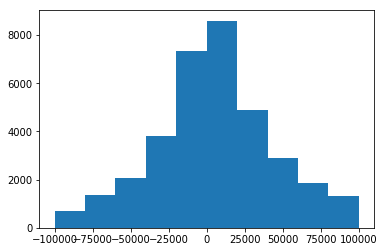

In [56]:
# Checking if savings is positive
print(np.count_nonzero(data['SAVINGS'] > 0) / data.shape[0])
hist = data['SAVINGS'].hist(bins=[-100000, -80000, -60000, -40000 ,-20000, 0, 20000, 40000, 60000, 80000, 100000], grid=False)

## Nice! Now checking for nulls/duplicates

In [57]:
print(data.isnull().sum().sum())
print(data.duplicated().sum())

0
0


## Good! Analyzing categorical features

### Regions

(17,)


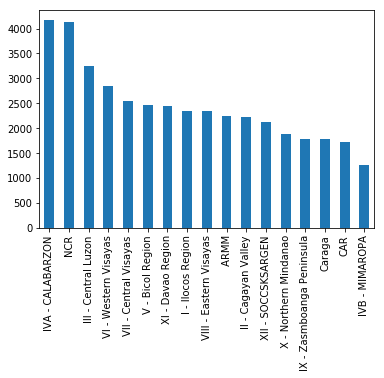

In [58]:
data['REGION'].value_counts().plot(kind='bar')
print(data['REGION'].value_counts().shape)

(5,)


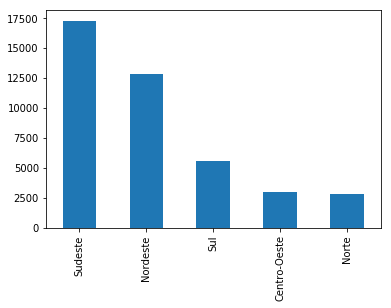

In [59]:
# Converting to brazilian regions, associating by gdp/capita in each region and by population
sudeste = ['IVA - CALABARZON', 'NCR', 'VII - Central Visayas', 'XI - Davao Region', 'XII - SOCCSKSARGEN', 'X - Northern Mindanao']
centro_oeste = ['CAR', 'IVB - MIMAROPA']
sul = ['III - Central Luzon', 'I - Ilocos Region']
norte = ['VI - Western Visayas']
nordeste = ['V - Bicol Region', 'VIII - Eastern Visayas', ' ARMM', 'II - Cagayan Valley', 'IX - Zasmboanga Peninsula', 'Caraga']

data.replace(sudeste, 'Sudeste', inplace=True)
data.replace(centro_oeste, 'Centro-Oeste', inplace=True)
data.replace(sul, 'Sul', inplace=True)
data.replace(norte, 'Norte', inplace=True)
data.replace(nordeste, 'Nordeste', inplace=True)

data['REGION'].value_counts().plot(kind='bar')
print(data['REGION'].value_counts().shape)

In [60]:
data.replace({'Sudeste': 1, 'Centro-Oeste': 2, 'Sul': 3, 'Norte': 4, 'Nordeste': 5}, inplace=True)

### Sex

(2,)


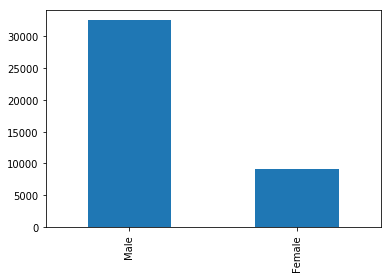

In [61]:
data['SEX'].value_counts().plot(kind='bar')
print(data['SEX'].value_counts().shape)

In [62]:
data.replace({'Male': 1, 'Female': 2}, inplace=True)

### Marriage

(6,)


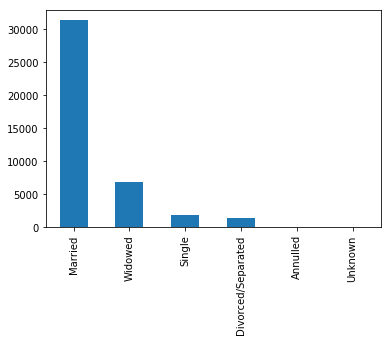

In [63]:
data['MARRIAGE'].value_counts().plot(kind='bar')
print(data['MARRIAGE'].value_counts().shape)

In [64]:
data.replace({'Married': 1, 'Widowed': 2, 'Single': 3, 'Divorced/Separated': 4}, inplace=True)
data.replace(['Annulled', 'Unknown'], 5, inplace=True)

## Converting Peso Filipino to Reais, and converting money values per year to 'per month'

In [65]:
mean_philippine = np.mean(data['INCOME'])
mean_brazil = 70000
data[['INCOME', 'SAVINGS', 'FOOD', 'SHOPPING', 'HOUSING', 'TRANSPORT', 'OTHERS']] *= mean_brazil / (mean_philippine * 12)

In [66]:
data = data.astype(int)
print(data.head())

   INCOME  REGION  SEX  AGE  MARRIAGE  SAVINGS  FOOD  SHOPPING  HOUSING  \
0   11318       2    2   49         3     4319  2776       911     1499   
1    4671       2    1   40         1      337  1596       409      974   
2    1950       2    1   39         1     -310  1451       216      337   
3    2535       2    1   52         1     -532  1842       121      392   
4    4461       2    1   65         1      352  2229       308      733   

   TRANSPORT  OTHERS  
0        112    1171  
1        303     943  
2          7      33  
3        161      35  
4        164      76  


# 2. What a fine thing! Doing a little bit of analysis/normalization

AxesSubplot(0.125,0.125;0.775x0.755)


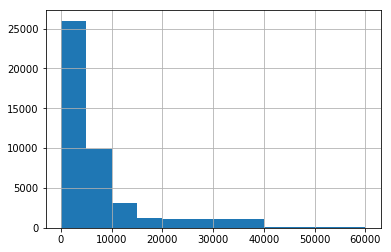

In [67]:
print(data['INCOME'].hist(bins=[0, 5000, 10000, 15000, 20000, 40000, 60000]))

Not cool.

Normalization

In [68]:
x = data.values
std_scaler = preprocessing.StandardScaler()
x_scaled = std_scaler.fit_transform(x)
data_norm = pd.DataFrame(x_scaled)

# 3. Trying out different clustering techniques

## 3.1. K-Means

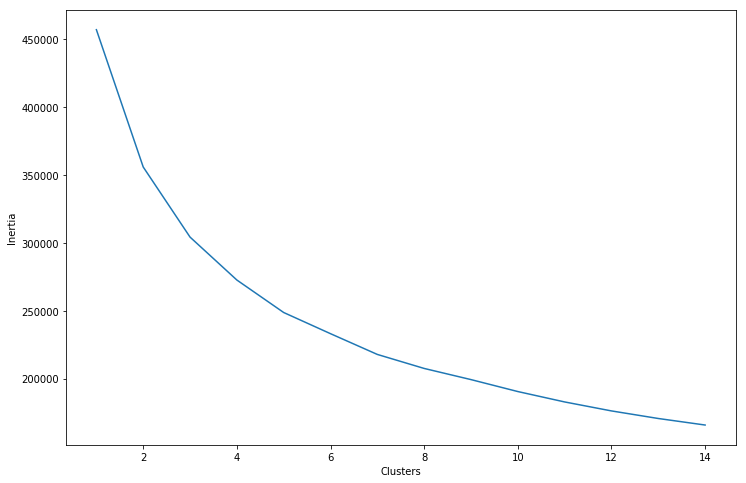

In [69]:
clusters = []
imax = 15

for i in range(1, imax):
    km = KMeans(n_clusters=i).fit(data_norm)
    clusters.append(km.inertia_)

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, imax)), y=clusters, ax=ax)
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')
plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


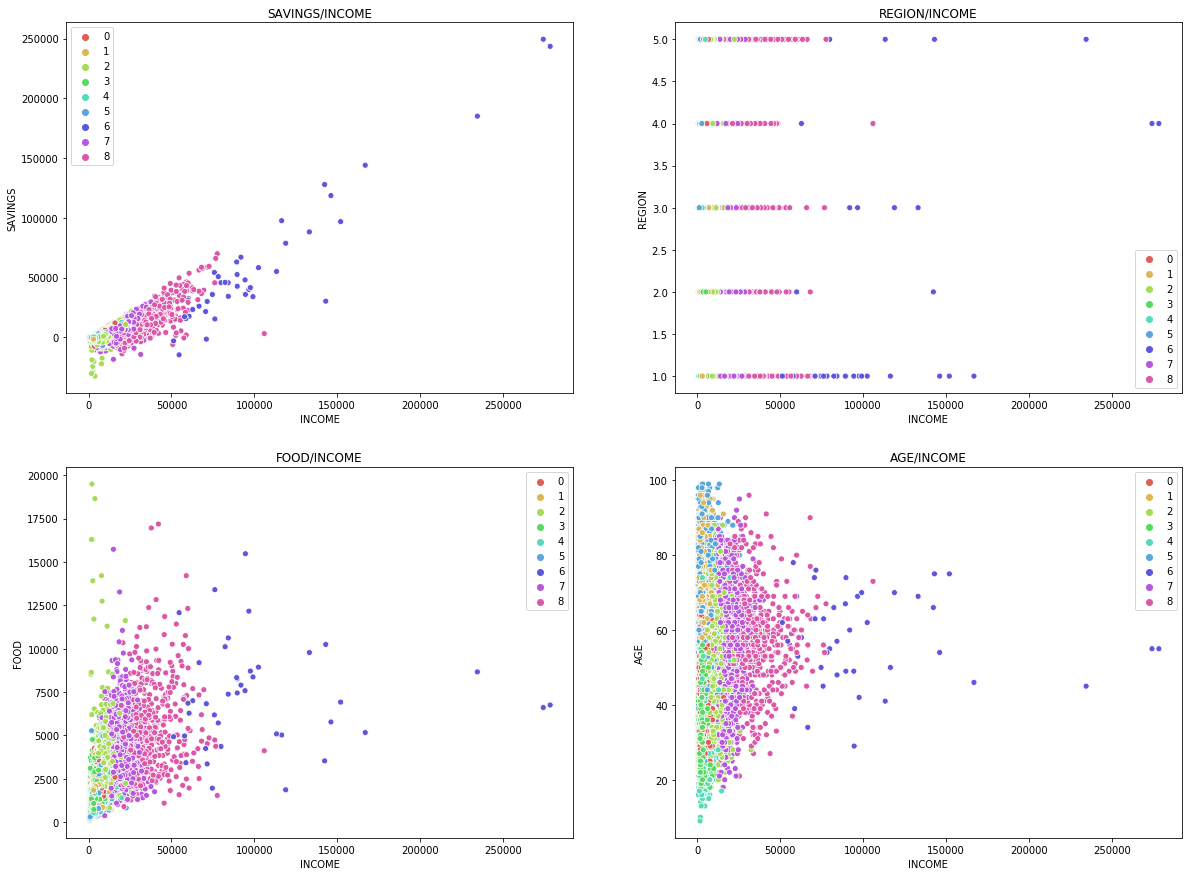

In [70]:
# 5 cluster
n_clusters = 9
km9 = KMeans(n_clusters=n_clusters).fit(data_norm)

fig = plt.figure(figsize=(20, 15))

ax = fig.add_subplot(221)
plt.subplot(2, 2, 1)
sns.scatterplot(data['INCOME'], data['SAVINGS'], hue=km9.labels_, 
                palette=sns.color_palette('hls', n_clusters))
ax.set_title('SAVINGS/INCOME')

ax = fig.add_subplot(222)
sns.scatterplot(data['INCOME'], data['REGION'], hue=km9.labels_, 
                palette=sns.color_palette('hls', n_clusters))
plt.title('REGION/INCOME')

ax = fig.add_subplot(223)
sns.scatterplot(data['INCOME'], data['FOOD'], hue=km9.labels_, 
                palette=sns.color_palette('hls', n_clusters))
ax.set_title('FOOD/INCOME')

ax = fig.add_subplot(224)
sns.scatterplot(data['INCOME'], data['AGE'], hue=km9.labels_, 
                palette=sns.color_palette('hls', n_clusters))
ax.set_title('AGE/INCOME')

plt.show()

In [88]:
unique, counts = np.unique(km9.labels_, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 9328]
 [   1 5592]
 [   2 5670]
 [   3 8890]
 [   4 2748]
 [   5 6158]
 [   6   41]
 [   7 2545]
 [   8  572]]


# 4. Output

## Suggestions for each category: average of the 70-80% savings quantile people

In [92]:
data['Labels'] = km9.labels_
categories = ['FOOD', 'HOUSING', 'TRANSPORT', 'SHOPPING', 'OTHERS', 'SAVINGS']
suggestions = {}
for i in range(n_clusters):
    cluster_data = data[data['Labels'] == i]
    cluster_data = cluster_data.sort_values(by=['SAVINGS'])
    cluster_data = cluster_data.iloc[int(0.7 * cluster_data.shape[0]):int(0.8 * cluster_data.shape[0])]
    sug = {cat: int(cluster_data[cat].mean()) for cat in categories}
    suggestions[i] = sug
print(suggestions)

{0: {'FOOD': 1549, 'HOUSING': 434, 'TRANSPORT': 133, 'SHOPPING': 215, 'OTHERS': 234, 'SAVINGS': 587}, 1: {'FOOD': 1439, 'HOUSING': 681, 'TRANSPORT': 135, 'SHOPPING': 221, 'OTHERS': 319, 'SAVINGS': 777}, 2: {'FOOD': 3000, 'HOUSING': 1469, 'TRANSPORT': 482, 'SHOPPING': 787, 'OTHERS': 886, 'SAVINGS': 2951}, 3: {'FOOD': 1641, 'HOUSING': 563, 'TRANSPORT': 176, 'SHOPPING': 252, 'OTHERS': 229, 'SAVINGS': 633}, 4: {'FOOD': 1524, 'HOUSING': 768, 'TRANSPORT': 201, 'SHOPPING': 302, 'OTHERS': 354, 'SAVINGS': 890}, 5: {'FOOD': 1662, 'HOUSING': 901, 'TRANSPORT': 193, 'SHOPPING': 318, 'OTHERS': 469, 'SAVINGS': 983}, 6: {'FOOD': 6760, 'HOUSING': 8260, 'TRANSPORT': 2367, 'SHOPPING': 3113, 'OTHERS': 10124, 'SAVINGS': 66814}, 7: {'FOOD': 3905, 'HOUSING': 2648, 'TRANSPORT': 838, 'SHOPPING': 1563, 'OTHERS': 1959, 'SAVINGS': 6907}, 8: {'FOOD': 5355, 'HOUSING': 4456, 'TRANSPORT': 1917, 'SHOPPING': 2204, 'OTHERS': 3465, 'SAVINGS': 19371}}


In [ ]:
print(data.head())

## Saving data

In [98]:
f = open('kmeans_data.pickle', 'wb')
pickle.dump([km9, std_scaler, suggestions], f)